In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.xlsx to data.xlsx


In [3]:
df = pd.read_excel('data.xlsx', index_col='Date', parse_dates=True)
df = df.asfreq('h')

In [4]:
df. info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26251 entries, 2020-12-31 15:00:00 to 2023-12-30 09:00:00
Freq: h
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   temperature_2m (°C)             26251 non-null  float64
 1   relative_humidity_2m (%)        26251 non-null  int64  
 2   wind_speed_10m (km/h)           26251 non-null  float64
 3   soil_moisture_0_to_7cm (m³/m³)  26251 non-null  float64
 4   direct_radiation (W/m²)         26251 non-null  int64  
 5   turbidity                       26251 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.4 MB


In [5]:
# create lag features of feature columns
df['relative_humidity_2m (%)_lag3'] = df['relative_humidity_2m (%)'].shift(3)
df['wind_speed_10m (km/h)_lag6'] = df['wind_speed_10m (km/h)'].shift(6)
df['soil_moisture_0_to_7cm (m³/m³)_lag72'] = df['soil_moisture_0_to_7cm (m³/m³)'].shift(72)
df['direct_radiation (W/m²)_lag72'] = df['direct_radiation (W/m²)'].shift(72)
df = df.dropna()

In [6]:
feature_columns = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'wind_speed_10m (km/h)', 'soil_moisture_0_to_7cm (m³/m³)', 'direct_radiation (W/m²)',
                   'relative_humidity_2m (%)_lag3', 'wind_speed_10m (km/h)_lag6', 'soil_moisture_0_to_7cm (m³/m³)_lag72', 'direct_radiation (W/m²)_lag72']

target_column = 'turbidity'

X = df[feature_columns]
y = df[target_column]


In [7]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# initialize XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)




In [10]:
# set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)



In [11]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'subsample': [0.5, 0.8, 1.0]
}



In [12]:
# perform GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, verbose=1)

In [13]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [14]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
Best Score: -3.872002314821117


In [15]:
# Get the best model from grid search
best_model = grid_search.best_estimator_


In [16]:
# Make predictions on the training and testing sets
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)



In [17]:
# calculate evaluation metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training MAE: {mae_train}")
print(f"Testing MAE: {mae_test}")

print(f"Training RMSE: {rmse_train}")
print(f"Testing RMSE: {rmse_test}")

print(f"Training R²: {r2_train}")
print(f"Testing R²: {r2_test}")

print(f"Training MAPE: {mape_train}")
print(f"Testing MAPE: {mape_test}")

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")


Training MAE: 1.0805770974532958
Testing MAE: 1.5824044761268592
Training RMSE: 1.5300081095710474
Testing RMSE: 2.027608121978768
Training R²: 0.29320997022338713
Testing R²: 0.006610929846581848
Training MAPE: 960034395168.5317
Testing MAPE: 0.9541779160011704
Training MSE: 2.34092481535317
Testing MSE: 4.111194696314266


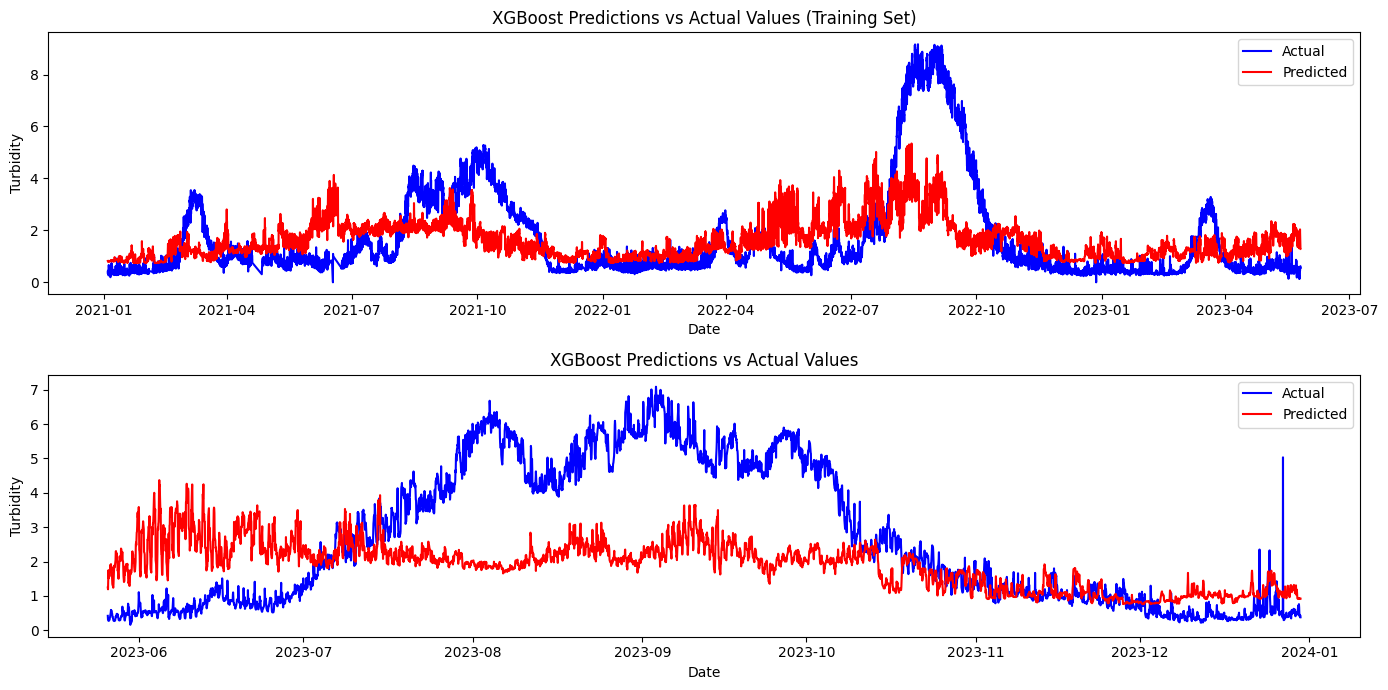

In [18]:
# Plot the predictions vs actual values for training and testing sets
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(y_train.index, y_train, label='Actual', color='blue')
plt.plot(y_train.index, y_train_pred, label='Predicted', color='red')
plt.title('XGBoost Predictions vs Actual Values (Training Set)')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red')
plt.title('XGBoost Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Feature importance
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

print("Feature importances:")
for idx in sorted_idx:
    print(f"{feature_columns[idx]}: {feature_importances[idx]:.4f}")

Feature importances:
temperature_2m (°C): 0.3138
soil_moisture_0_to_7cm (m³/m³)_lag72: 0.1495
relative_humidity_2m (%)_lag3: 0.1081
direct_radiation (W/m²)_lag72: 0.1004
direct_radiation (W/m²): 0.0943
soil_moisture_0_to_7cm (m³/m³): 0.0812
relative_humidity_2m (%): 0.0775
wind_speed_10m (km/h): 0.0428
wind_speed_10m (km/h)_lag6: 0.0325


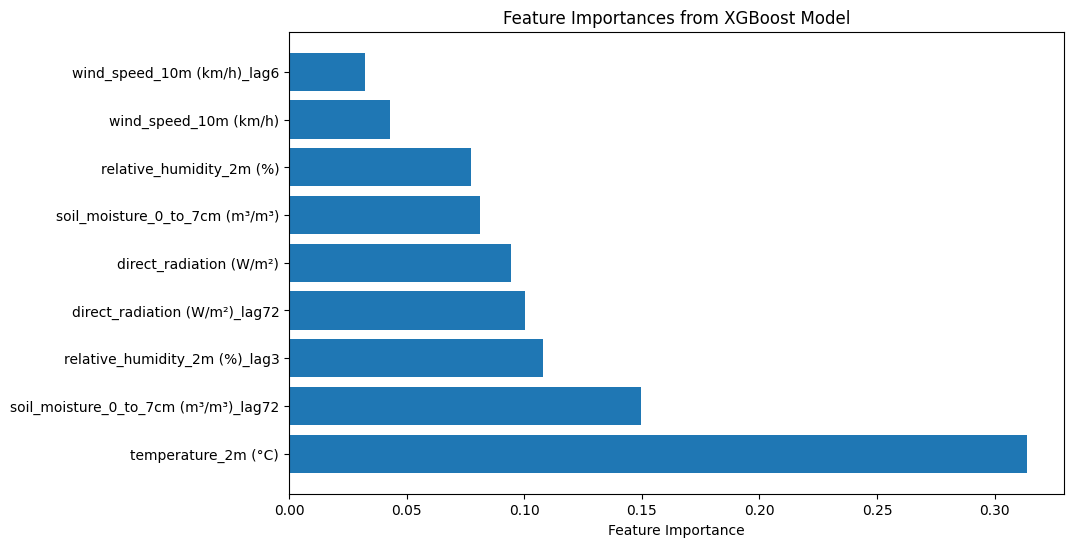

In [20]:
# plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), [feature_columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from XGBoost Model')
plt.show()